In [74]:
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from proteinbert import load_pretrained_model


BENCHMARK_NAME = 'fluorescence'
BENCHMARKS_DIR = 'protein_bert/protein_benchmarks'

train_set_file_path = os.path.join(BENCHMARKS_DIR, f'{BENCHMARK_NAME}.train.csv')
train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
train_set, valid_set = train_test_split(train_set, test_size=0.1, random_state=0)

test_set_file_path = os.path.join(BENCHMARKS_DIR, f'{BENCHMARK_NAME}.test.csv')
test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()

In [75]:
# load the model_encoder
pretrained_model_generator, input_encoder = load_pretrained_model()

def encode_sequences_with_merge(sequences, encoder, seq_len=512):
    encoded = encoder.encode_X(sequences, seq_len=seq_len)
    valid_encoded = encoded[0] if isinstance(encoded, list) else encoded
    return valid_encoded

train_features = encode_sequences_with_merge(train_set['seq'], input_encoder, seq_len=512)
valid_features = encode_sequences_with_merge(valid_set['seq'], input_encoder, seq_len=512)
test_features = encode_sequences_with_merge(test_set['seq'], input_encoder, seq_len=512)

In [76]:
train_set.head()

,seq,label
20255,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGELTLKFI...,3.282591
16949,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKSI...,3.126132
13334,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,3.609055
6847,SKGEELFTGVVPILVELDGDVDGHKFSVSGEGEGDATYGKLTLKFI...,3.591338
5472,SKGEELFTGVVPILVEPDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,1.409973


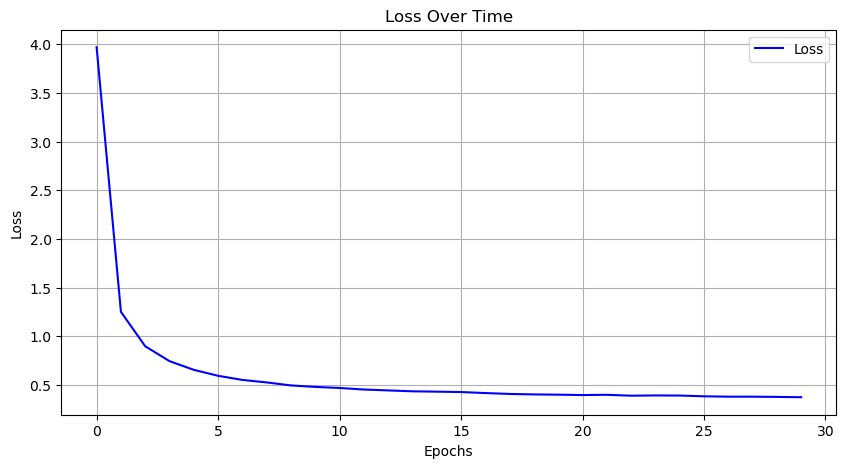

851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - loss: 1.6075 - mean_squared_error: 1.6075
Test Loss (MSE): 1.61394464969635, Test MSE: 1.61394464969635


In [77]:
# MLP

def build_mlp(input_dim, output_dim=1):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(256, activation='relu'),  # 增加神经元数量
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(output_dim, activation='linear')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    return model

mlp_model = build_mlp(input_dim=train_features.shape[1])

# train the MLP
# mlp_model.fit(
#     train_features, train_set['label'],
#     validation_data=(valid_features, valid_set['label']),
#     epochs=20,
#     batch_size=32,
#     callbacks=[
#         keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
#     ]
# )

history = mlp_model.fit(
    train_features, train_set['label'],
    validation_data=(valid_features, valid_set['label']),
    epochs=30,
    batch_size=32,
    verbose=0
).history

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Loss', color='blue')
# plt.plot(history['val_loss'], label='Validation Loss', color='red')
plt.title('Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

test_loss, test_mse = mlp_model.evaluate(test_features, test_set['label'], batch_size=32)
print(f'Test Loss (MSE): {test_loss}, Test MSE: {test_mse}')

In [65]:
import shap

def predict_wrapper(sequences):
    encoded_sequences = input_encoder.encode_X(sequences, seq_len=512)
    predictions = mlp_model.predict(encoded_sequences)
    print("Predictions shape:", predictions.shape)
    return np.array(predictions)

class ModelWrapper:
    def __init__(self, encoder, mlp_model):
        self.encoder = encoder
        self.mlp_model = mlp_model

    def predict(self, sequences):
        encoded_sequences = self.encoder.encode_X(sequences, seq_len=512)
        return self.mlp_model.predict(encoded_sequences)

combined_model = ModelWrapper(input_encoder, mlp_model)
explainer = shap.Explainer(combined_model.predict, input_encoder)

In [78]:
import shap
import numpy as np
import matplotlib.pyplot as plt

background = train_features[np.random.choice(train_features.shape[0], 100, replace=False)]
explainer = shap.KernelExplainer(mlp_model.predict, background)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [79]:
# Calculate SHAP values for a subset of the test set
shap_values = explainer.shap_values(test_features[:50])  # Limiting to 50 examples for speed

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7232/7232 ━━━━━━━━━━━━━━━━━━━━ 6s 802us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7238/7238 ━━━━━━━━━━━━━━━━━━━━ 5s 654us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7232/7232 ━━━━━━━━━━━━━━━━━━━━ 4s 592us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7238/7238 ━━━━━━━━━━━━━━━━━━━━ 4s 596us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7250/7250 ━━━━━━━━━━━━━━━━━━━━ 6s 792us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7232/7232 ━━━━━━━━━━━━━━━━━━━━ 6s 817us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7244/7244 ━━━━━━━━━━━━━━━━━━━━ 5s 644us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7232/7232 ━━━━━━━━━━━━━━━━━━━━ 4s 580us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7244/7244 ━━━━━━━━━━━━━━━━━━━━ 4s 582us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7244/7244 ━━━━━━━━━━━━━━━━━━━━ 4s 583us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 4s 591us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7244/7244 ━━━━━━━━━━━━━━━━━━━━ 4s 576us/step
1/1 

In [82]:
test_features = test_features.astype('float64')
shap_values = np.array(shap_values).astype('float64')
shap.force_plot(explainer.expected_value, shap_values[0], test_features[1])

In [30]:
shap.plots.text(shap_values[0])
print(train_set['seq'][0])

AttributeError: 'numpy.ndarray' object has no attribute 'output_names'

In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from proteinbert import load_pretrained_model
from scipy.stats import spearmanr

BENCHMARK_NAME = 'stability'
BENCHMARKS_DIR = 'protein_bert/protein_benchmarks'

train_set_file_path = os.path.join(BENCHMARKS_DIR, f'{BENCHMARK_NAME}.train.csv')
train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
train_set, valid_set = train_test_split(train_set, test_size=0.1, random_state=0)

test_set_file_path = os.path.join(BENCHMARKS_DIR, f'{BENCHMARK_NAME}.test.csv')
test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()

# load the model_encoder
pretrained_model_generator, input_encoder = load_pretrained_model()

def encode_sequences_with_merge(sequences, encoder, seq_len=512):
    encoded = encoder.encode_X(sequences, seq_len=seq_len)
    valid_encoded = encoded[0] if isinstance(encoded, list) else encoded
    return valid_encoded

train_features = encode_sequences_with_merge(train_set['seq'], input_encoder, seq_len=512)
valid_features = encode_sequences_with_merge(valid_set['seq'], input_encoder, seq_len=512)
test_features = encode_sequences_with_merge(test_set['seq'], input_encoder, seq_len=512)

# MLP
def build_mlp(input_dim, output_dim=1):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(output_dim, activation='linear')  # Regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return model

mlp_model = build_mlp(input_dim=train_features.shape[1])

# train the MLP
mlp_model.fit(
    train_features, train_set['label'],
    validation_data=(valid_features, valid_set['label']),
    epochs=50,
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# Evaluate the MLP
test_loss, test_mse = mlp_model.evaluate(test_features, test_set['label'], batch_size=32)
print(f'Test Loss (MSE): {test_loss}, Test MSE: {test_mse}')

# Calculate Spearman's correlation manually
predictions = mlp_model.predict(test_features)
spearman_corr = spearmanr(test_set['label'], predictions.flatten()).correlation
print(f'Test Spearman’s Correlation: {spearman_corr}')
